# Лабораторная работа №2
## Нейросетевое моделирование временного ряда

**Цель:**
Провести моделирование временного ряда из ЛР №1 с помощью нейросетевых методов, выполнить прогноз на разумный период, оценить качество модели, визуализировать результат с учетом ошибок и сравнить с классической моделью (SARIMA).

В качестве нейросетевого метода выбрана **LSTM (Long Short-Term Memory)** — рекуррентная нейронная сеть, специально предназначенная для работы с временными рядами и последовательностями.


In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import periodogram
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm
import scripts_no_pandas as tsg

In [150]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

тип тренда: logarithmic


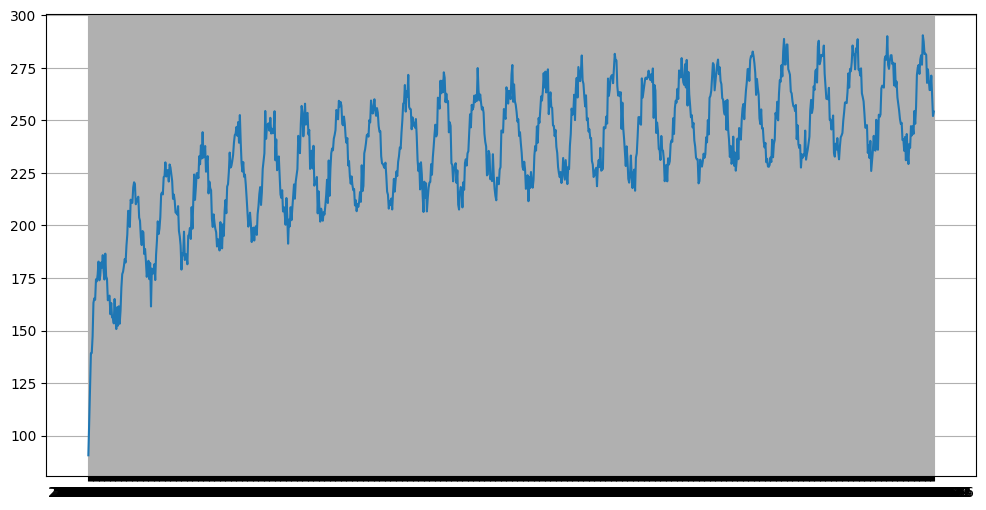

In [151]:
dates, values, trend_type = tsg.generate_time_series(n_points=1000, seed=42)
df = pd.DataFrame({'value': values}, index=dates)
print(f"тип тренда: {trend_type}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'])
plt.grid(True)
plt.show()

In [152]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(df['value'].values.reshape(-1, 1))

SEQ_LENGTH = 60 
PREDICT_HORIZON = 80 

In [153]:
X, y = create_sequences(data_normalized, SEQ_LENGTH)

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

batch_size = 16
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [154]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, seq_length):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        linear_input_size = 64 * (seq_length - 2)       
        self.linear1 = nn.Linear(linear_input_size, 50)
        self.linear2 = nn.Linear(50, 1) 

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model = TimeSeriesCNN(seq_length=SEQ_LENGTH)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [155]:
epochs = 50
losses = []

for epoch in tqdm(range(epochs), desc="Training"):
    model.train()
    epoch_loss = 0.0
    epoch_mae = 0.0

    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_mae += torch.mean(torch.abs(y_pred - labels)).item()

    epoch_loss /= len(train_loader)
    epoch_mae /= len(train_loader)

    losses.append(epoch_loss)

    print(
        f"Epoch {epoch+1}/{epochs} "
        f"{len(train_loader)}/{len(train_loader)} "
        f"- loss: {epoch_loss:.4f} "
        f"- mae: {epoch_mae:.4f}"
    )


Training:   4%|▍         | 2/50 [00:00<00:03, 13.72it/s]

Epoch 1/50 50/50 - loss: 0.0286 - mae: 0.1042
Epoch 2/50 50/50 - loss: 0.0219 - mae: 0.1079
Epoch 3/50 50/50 - loss: 0.0054 - mae: 0.0567



Training:  12%|█▏        | 6/50 [00:00<00:03, 13.38it/s]

Epoch 4/50 50/50 - loss: 0.0034 - mae: 0.0470
Epoch 5/50 50/50 - loss: 0.0031 - mae: 0.0443
Epoch 6/50 50/50 - loss: 0.0029 - mae: 0.0432



Training:  16%|█▌        | 8/50 [00:00<00:03, 13.53it/s]

Epoch 7/50 50/50 - loss: 0.0027 - mae: 0.0420
Epoch 8/50 50/50 - loss: 0.0027 - mae: 0.0417
Epoch 9/50 50/50 - loss: 0.0027 - mae: 0.0415



Training:  24%|██▍       | 12/50 [00:00<00:02, 13.45it/s]

Epoch 10/50 50/50 - loss: 0.0026 - mae: 0.0414
Epoch 11/50 50/50 - loss: 0.0026 - mae: 0.0413
Epoch 12/50 50/50 - loss: 0.0026 - mae: 0.0412



Training:  28%|██▊       | 14/50 [00:01<00:02, 13.15it/s]

Epoch 13/50 50/50 - loss: 0.0026 - mae: 0.0411
Epoch 14/50 50/50 - loss: 0.0026 - mae: 0.0410
Epoch 15/50 50/50 - loss: 0.0025 - mae: 0.0408



Training:  36%|███▌      | 18/50 [00:01<00:02, 12.40it/s]

Epoch 16/50 50/50 - loss: 0.0031 - mae: 0.0436
Epoch 17/50 50/50 - loss: 0.0028 - mae: 0.0425
Epoch 18/50 50/50 - loss: 0.0026 - mae: 0.0410



Training:  40%|████      | 20/50 [00:01<00:02, 12.40it/s]

Epoch 19/50 50/50 - loss: 0.0026 - mae: 0.0406
Epoch 20/50 50/50 - loss: 0.0027 - mae: 0.0416
Epoch 21/50 50/50 - loss: 0.0025 - mae: 0.0405



Training:  48%|████▊     | 24/50 [00:01<00:02, 12.33it/s]

Epoch 22/50 50/50 - loss: 0.0025 - mae: 0.0401
Epoch 23/50 50/50 - loss: 0.0025 - mae: 0.0406
Epoch 24/50 50/50 - loss: 0.0025 - mae: 0.0402



Training:  52%|█████▏    | 26/50 [00:02<00:01, 12.35it/s]

Epoch 25/50 50/50 - loss: 0.0025 - mae: 0.0404
Epoch 26/50 50/50 - loss: 0.0025 - mae: 0.0405
Epoch 27/50 50/50 - loss: 0.0025 - mae: 0.0406



Training:  60%|██████    | 30/50 [00:02<00:01, 12.19it/s]

Epoch 28/50 50/50 - loss: 0.0025 - mae: 0.0403
Epoch 29/50 50/50 - loss: 0.0025 - mae: 0.0405
Epoch 30/50 50/50 - loss: 0.0025 - mae: 0.0398



Training:  64%|██████▍   | 32/50 [00:02<00:01, 12.27it/s]

Epoch 31/50 50/50 - loss: 0.0025 - mae: 0.0403
Epoch 32/50 50/50 - loss: 0.0025 - mae: 0.0399
Epoch 33/50 50/50 - loss: 0.0026 - mae: 0.0410



Training:  72%|███████▏  | 36/50 [00:02<00:01, 12.34it/s]

Epoch 34/50 50/50 - loss: 0.0025 - mae: 0.0399
Epoch 35/50 50/50 - loss: 0.0026 - mae: 0.0406
Epoch 36/50 50/50 - loss: 0.0025 - mae: 0.0398



Training:  76%|███████▌  | 38/50 [00:03<00:00, 12.39it/s]

Epoch 37/50 50/50 - loss: 0.0025 - mae: 0.0401
Epoch 38/50 50/50 - loss: 0.0024 - mae: 0.0397
Epoch 39/50 50/50 - loss: 0.0025 - mae: 0.0397



Training:  84%|████████▍ | 42/50 [00:03<00:00, 12.43it/s]

Epoch 40/50 50/50 - loss: 0.0024 - mae: 0.0391
Epoch 41/50 50/50 - loss: 0.0024 - mae: 0.0391
Epoch 42/50 50/50 - loss: 0.0023 - mae: 0.0387



Training:  88%|████████▊ | 44/50 [00:03<00:00, 12.44it/s]

Epoch 43/50 50/50 - loss: 0.0024 - mae: 0.0389
Epoch 44/50 50/50 - loss: 0.0024 - mae: 0.0388
Epoch 45/50 50/50 - loss: 0.0024 - mae: 0.0387



Training:  96%|█████████▌| 48/50 [00:03<00:00, 12.05it/s]

Epoch 46/50 50/50 - loss: 0.0024 - mae: 0.0390
Epoch 47/50 50/50 - loss: 0.0023 - mae: 0.0385
Epoch 48/50 50/50 - loss: 0.0024 - mae: 0.0387



Training: 100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

Epoch 49/50 50/50 - loss: 0.0023 - mae: 0.0383
Epoch 50/50 50/50 - loss: 0.0024 - mae: 0.0388


In [156]:
model.eval()
with torch.no_grad():
    test_preds_scaled = model(X_test).numpy()

test_preds = scaler.inverse_transform(test_preds_scaled)
y_test_real = scaler.inverse_transform(y_test.numpy())

mae = mean_absolute_error(y_test_real, test_preds)
rmse = np.sqrt(mean_squared_error(y_test_real, test_preds))
mape = np.mean(np.abs((y_test_real - test_preds) / y_test_real)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 4.339920997619629
RMSE: 5.499017454295493
MAPE: 1.6645584106445312%


In [157]:
residuals = y_test_real - test_preds
std_error = np.std(residuals)

future_predictions_scaled = []
current_seq = torch.FloatTensor(data_normalized[-SEQ_LENGTH:]).view(1, SEQ_LENGTH, 1)

for _ in range(PREDICT_HORIZON):
    with torch.no_grad():
        pred = model(current_seq)
        future_predictions_scaled.append(pred.item())
        new_seq = torch.cat((current_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
        current_seq = new_seq

forecast = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

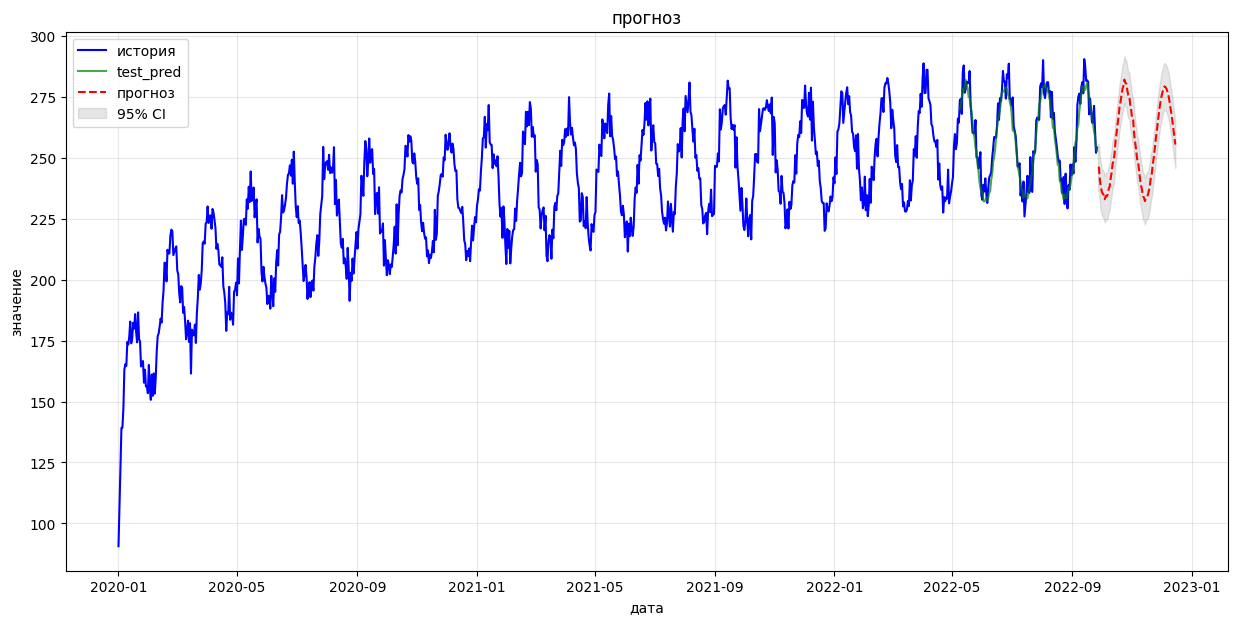

In [158]:
df.index = pd.to_datetime(df.index)
last_date = df.index[-1]
future_dates = [pd.to_datetime(last_date).date() + timedelta(days=i) for i in range(1, PREDICT_HORIZON + 1)]
ci_lower = forecast - 1.96 * std_error
ci_upper = forecast + 1.96 * std_error


plt.figure(figsize=(15, 7))

plot_start = max(0, len(df) - 1000)
plt.plot(df.index[plot_start:], df['value'].iloc[plot_start:], label='история', color='blue')

test_dates = df.index[SEQ_LENGTH + train_size:]
limit = len(test_preds)
plt.plot(test_dates[:limit], test_preds[:limit], label='test_pred', color='green', alpha=0.7)

plt.plot(future_dates, forecast, label='прогноз', color='red', linestyle='--')
plt.fill_between(future_dates, ci_lower, ci_upper, color='gray', alpha=0.2, label='95% CI')

plt.title('прогноз')
plt.xlabel('дата')
plt.ylabel('значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

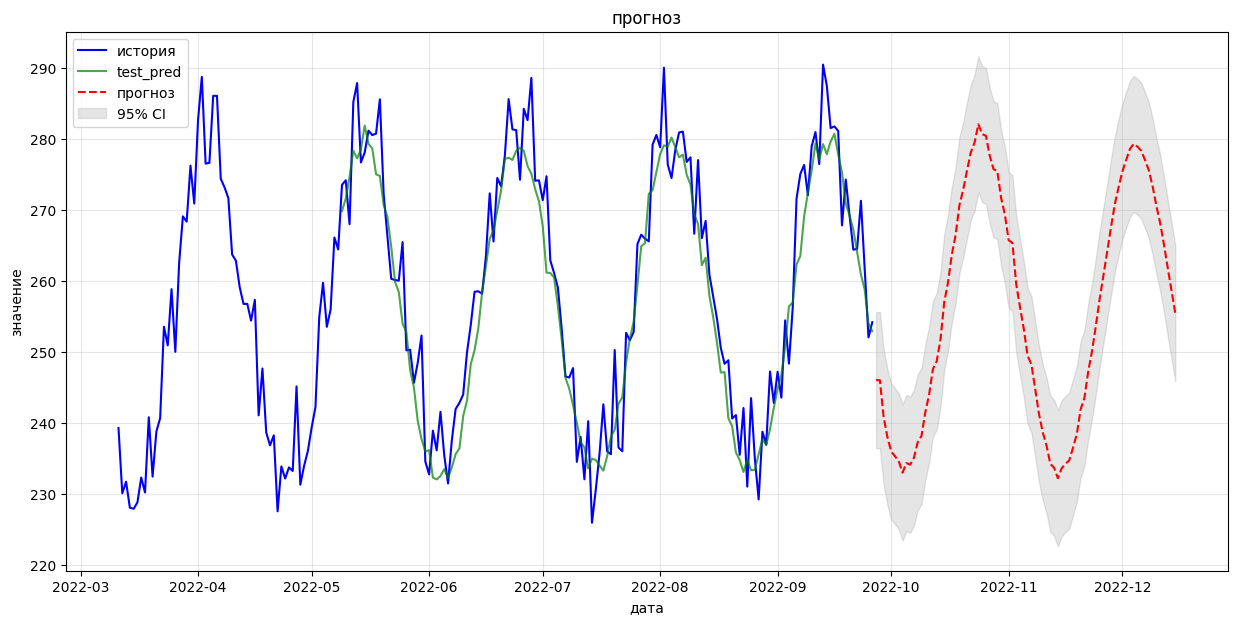

In [159]:
plt.figure(figsize=(15, 7))

plot_start = max(0, len(df) - 200)
plt.plot(df.index[plot_start:], df['value'].iloc[plot_start:], label='история', color='blue')

test_dates = df.index[SEQ_LENGTH + train_size:]
limit = len(test_preds)
plt.plot(test_dates[:limit], test_preds[:limit], label='test_pred', color='green', alpha=0.7)

plt.plot(future_dates, forecast, label='прогноз', color='red', linestyle='--')
plt.fill_between(future_dates, ci_lower, ci_upper, color='gray', alpha=0.2, label='95% CI')

plt.title('прогноз')
plt.xlabel('дата')
plt.ylabel('значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

На тестовом участке: Метрики CNN (MAE/MAPE) лучше регрессии. CNN лучше подстраивается под мелкие неровности и шум, которые регрессия игнорирует, сглаживая всё в линию.

На будущем прогнозе: Регрессия даст более реалистичный результат, в то время как ошибка CNN будет расти с каждым шагом прогноза из-за потери тренда.